In [59]:
import torch
import torchvision
import torch.nn.functional as F
from torchvision.models import inception_v3, Inception_V3_Weights
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import scipy as scp

from wgan.model import generator
from vae.model import VAE
from ddpm.diffusion import DiffusionProcess
from ddpm.model import UNetModel

In [60]:
def rescale(x):
    """rescale images in the interval [0, 1]"""
    x_min, _ = x.flatten(1, -1).min(dim=1)
    x_max, _ = x.flatten(1, -1).max(dim=1)
    return (x - x_min[:, None, None, None]) / (x_max - x_min)[:, None, None, None]

def transform_for_inception(x):
    """resize the images to (3, 299, 299) to pass through inceptionv3"""
    x = F.interpolate(x, size=(299, 299), mode='bicubic')
    x = x.permute(0, 2, 3, 1)
    x = x.repeat(1, 1, 1, 3)
    return x.permute(0, 3, 1, 2)

def get_inceptionv3_model():
    """get the pretrained inceptionv3 model"""
    model = inception_v3(weights=Inception_V3_Weights)
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    model.avgpool.register_forward_hook(get_activation('avgpool'))
    return model, activation

def generate_images_via_WGAN(num_images, device, bs=100):
    """generated images from the WGAN"""
    model_path = "wgan/weights/generator_weights.pth"
    args = OmegaConf.load('wgan/config.yaml')
    gen_model = generator(args.dim)
    gen_model.load_state_dict(torch.load(model_path))
    gen_model.to(device)

    gen_model.eval()

    sizes = [bs] * (num_images // bs) + [num_images % bs]
    gen_images = []
    progress = tqdm(sizes)
    with torch.no_grad():
        for size in progress:
            noise = torch.randn(size, 100, 1, 1).to(device)
            out = gen_model(noise)
            gen_images.append(
                out.detach().cpu()
            )    
    return torch.cat(gen_images, axis=0)

def generate_images_via_VAE(num_images, device, bs=100):
    """generated images from the VAE"""
    model_path = "vae/weights/vae_weights.pth"
    args = OmegaConf.load('vae/config.yaml')
    gen_model = VAE(args)
    gen_model.load_state_dict(torch.load(model_path))
    gen_model.to(device)

    gen_model.eval()

    sizes = [bs] * (num_images // bs) + [num_images % bs]
    gen_images = []
    progress = tqdm(sizes)
    with torch.no_grad():
        for size in progress:
            noise = torch.randn(size, args.latent_dim).to(device)
            out = gen_model.decoder(noise)
            out = out.view(size, 1, args.image_size, args.image_size)
            gen_images.append(
                out.detach().cpu()
            )    
    return torch.cat(gen_images, axis=0)

def generate_images_via_DDPM(num_images, device, bs=100):
    """generated images from the DDPM"""
    model_path = "ddpm/weights/ddpm_weights_1000.pth"
    args = OmegaConf.load('ddpm/config.yaml')

    # model
    model = UNetModel(
        in_channels=1,
        n_feat=128
    )
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    # diffusion process
    ddpm = DiffusionProcess(
        betas=(1e-4, 0.02),
        T=args.T,
        device=device
    )

    model.eval()

    sizes = [bs] * (num_images // bs) + [num_images % bs]
    gen_images = []
    progress = tqdm(sizes)
    with torch.no_grad():
        for size in progress:
            out = ddpm.sample(model, (size, 1, args.image_size, args.image_size))
            gen_images.append(
                out.detach().cpu()
            )    
    return torch.cat(gen_images, axis=0)


def get_inception_activations(im, device):
    """Get the output from the average pooling layer of the inceptionv3 model"""
    im = transform_for_inception(im)
    im = rescale(im)

    dataset = torch.utils.data.TensorDataset(im)
    loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)

    model, activation = get_inceptionv3_model()
    model.to(device)

    outputs = []
    progress = tqdm(loader)
    for data in progress:
        out = model(data[0].float().to(device))
        outputs.append(
            activation['avgpool'].squeeze()
        )
    return torch.cat(outputs, axis=0)

def compute_stats(im, device):
    """Compute mean vector and covariance matrix of the inception outputs"""
    act = get_inception_activations(im, device).detach().cpu().numpy()
    return np.mean(act, axis=0), np.cov(act, rowvar=False)

def compute_fid_score(im1, im2, device):
    """Compute the FID score (i.e. 2-Wasserstein Distance betwee 2 Gaussians)"""
    mu1, sigma1 = compute_stats(im1, device)
    mu2, sigma2 = compute_stats(im2, device)

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = scp.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    tr_covmean = np.trace(covmean)
    if not np.isfinite(covmean).all():
        msg = (
            "fid calculation produces singular product; "
            "adding %s to diagonal of cov estimates"
        ) % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


In [61]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
dataset = torchvision.datasets.MNIST(
            root='data',
            train=False,
            download=True,
        )

num_images = 5000
im_true = dataset.data[np.random.permutation(len(dataset))][:num_images].unsqueeze(1)

In [62]:
im_wgan = generate_images_via_WGAN(num_images, device)
im_vae = generate_images_via_VAE(num_images, device)
im_ddpm = generate_images_via_DDPM(num_images, device)

100%|██████████| 51/51 [25:30<00:00, 30.02s/it]


In [63]:
fid_wgan = compute_fid_score(im_wgan, im_true, device)
fid_vae = compute_fid_score(im_vae, im_true, device)
fid_ddpm = compute_fid_score(im_ddpm, im_true, device)

/cis/home/adesilva/miniconda3/envs/prol/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 94%|█████████▍| 47/50 [00:07<00:00,  6.11it/s]

100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


In [64]:
print(
    f"VAE FID: {fid_vae:.4f} \n WGAN FID: {fid_wgan:.4f} \n DDPM FID: {fid_ddpm:.4f}"
)

VAE FID: 16.3095 
 WGAN FID: 12.4005 
 DDPM FID: 13.4285


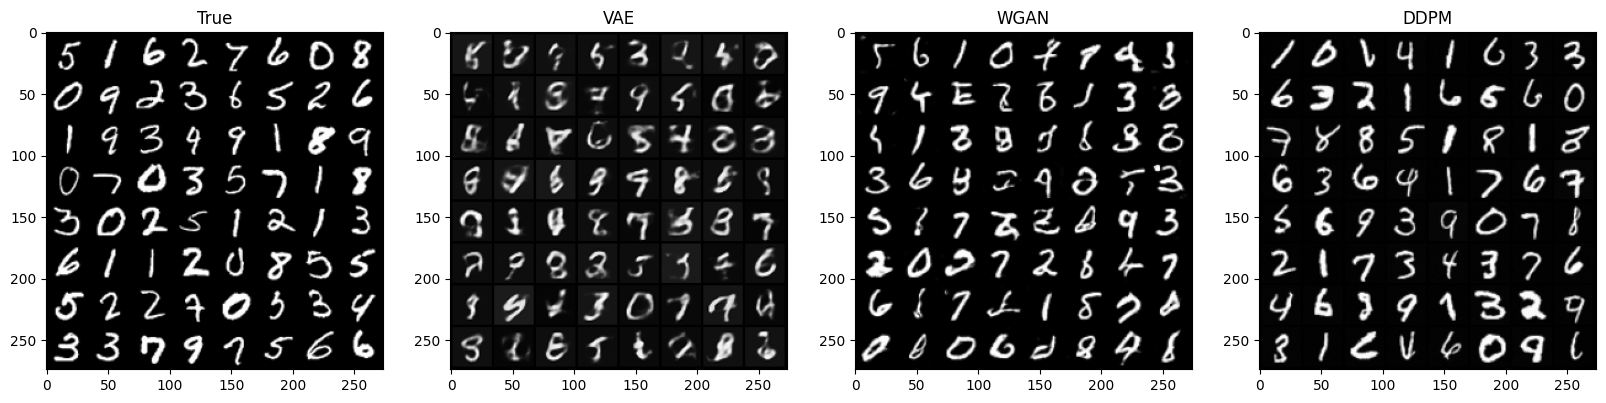

In [66]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
imgs = [im_true, im_vae, im_wgan, im_ddpm]
titles = ["True", "VAE", "WGAN", "DDPM"]
for i, pack in enumerate(zip(imgs, titles)):
    img, title = pack
    ax = axes[i]
    im = img[:64]
    im = F.interpolate(im, size=(32, 32), mode='bicubic')
    im = rescale(im)    
    grid = torchvision.utils.make_grid(im, nrow=8)
    ax.imshow(grid.permute(1, 2, 0))
    ax.set_title(title)